# FF-VUS

## Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from matplotlib.gridspec import GridSpec

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

experiments_path = os.path.join('..', '..', 'experiments')
save_fig_path = os.path.join(experiments_path, 'figures')
os.makedirs(save_fig_path, exist_ok=True)

In [200]:
# Consistent color palette
color_palette = {
    'FF-VUS (L: 128)': '#c8b400',          # Good
    'FF-VUS-GPU (L: 128)': '#40da70',     # Very Good
    'AUC': '#f1a73f',                # Secondary competitor
    'VUS (L: 128)': '#b02a41',            # Main competitor
    'AFFILIATION': '#A5D1C2',        # Useless competitors
    'Range-AUC (L: 128)': '#547C6E',       # Useless competitors
    'RF': '#123327',                    # Useless competitors
}

# Map shorthand names to formal names
formal_names = {
    'FF-VUS': 'FF-VUS (L: 128)',
    'FF-VUS-GPU': 'FF-VUS-GPU (L: 128)',
    'AUC': 'AUC',
    'VUS': 'VUS (L: 128)',
    'RF': 'RF',
    'AFFILIATION': 'AFFILIATION',
    'RANGE-AUC': 'Range-AUC (L: 128)',
}

# Default seaborn style
sns.set_style("whitegrid")

In [3]:
def finalize_plot(save_dir, filename):
    plt.tight_layout()
    if filename is not None:
        save_path = os.path.join(save_dir, filename)
        # plt.savefig(f"{save_path}.svg", bbox_inches='tight')
        plt.savefig(f"{save_path}.pdf", bbox_inches='tight')
    plt.show()

def load_results(path):
    result_files = [file for file in os.listdir(path) if file.endswith('.csv')]

    df = pd.DataFrame()
    for file in tqdm(result_files):
        file_path = os.path.join(path, file)
        curr_df = pd.read_csv(file_path, index_col=0).reset_index()
        df = pd.concat([df, curr_df], ignore_index=True)
    return df


## Experiment 1: All metrics with default parameters on the TSB-UAD benchmark

In [4]:
curr_experiment_path = os.path.join(experiments_path, 'allmetrics_defparams_tsb', 'results')
df = load_results(curr_experiment_path)    
df['Metric'] = df['Metric'].map(formal_names)
df.sample(3)

100%|██████████| 7/7 [00:00<00:00, 97.09it/s]


,Time series,Length,Number of anomalies,Anomalies average length,Slope size,Metric,Metric value,Metric time,Existence,Step,...,Anomaly coordinates time,Safe mask time,Thresholds time,Score mask time,Position time,Slopes time,Existence time,Confusion matrix time,Precision recall curve time,Integral time
4431,OPPORTUNITY/S4-ADL3.test.csv@16.out,24524,2,556.000000,NaN,AFFILIATION,0.706641,0.006413,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8524,SMD/machine-2-2.test.csv@11.out,23699,11,257.545455,NaN,RF,0.087422,0.121108,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11294,KDD21/044_UCR_Anomaly_DISTORTEDPowerDemand1_90...,29930,1,336.000000,128.0,FF-VUS (L: 128),0.568150,0.003718,optimized,1.0,...,0.000081,0.000188,0.000301,0.000567,0.000075,0.000105,0.000136,0.000606,0.000157,0.000066


In [5]:
metric_to_compare = 'VUS (L: 128)'

df_vus = df[df['Metric'] == metric_to_compare].set_index('Time series')
for metric in df['Metric'].unique():
    curr_df = df[df['Metric'] == metric].set_index('Time series')

    common_index = df_vus.index.intersection(curr_df.index)
    curr_speed_up = df_vus.loc[common_index, 'Metric time'] / curr_df.loc[common_index, 'Metric time']
    print(f"{metric}: {curr_speed_up.mean():.2f}x speed up")

Range-AUC (L: 128): 58.31x speed up
VUS (L: 128): 1.00x speed up
AFFILIATION: 128.03x speed up
AUC: 480.69x speed up
RF: 17.24x speed up
FF-VUS (L: 128): 110.71x speed up
FF-VUS-GPU (L: 128): 467.44x speed up


### Runtime Box plots

In [6]:
metric_to_compare = 'VUS (L: 128)'
speed_up_dict = {}

df_vus = df[df['Metric'] == metric_to_compare].set_index('Time series')
for metric in df['Metric'].unique():
    curr_df = df[df['Metric'] == metric].set_index('Time series')

    common_index = df_vus.index.intersection(curr_df.index)
    curr_speed_up = df_vus.loc[common_index, 'Metric time'] / curr_df.loc[common_index, 'Metric time']
    speed_up_dict[metric] = curr_speed_up.mean()
    print(f"{metric}: {speed_up_dict[metric]:.2f}x speed up")

Range-AUC (L: 128): 58.31x speed up
VUS (L: 128): 1.00x speed up
AFFILIATION: 128.03x speed up
AUC: 480.69x speed up
RF: 17.24x speed up
FF-VUS (L: 128): 110.71x speed up
FF-VUS-GPU (L: 128): 467.44x speed up


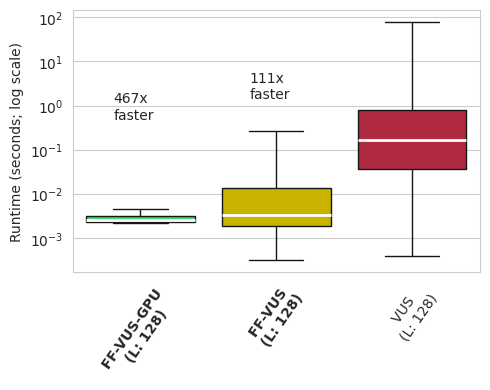

In [110]:
# What is the execution time difference
median_times = df.groupby('Metric')['Metric time'].median()
order = median_times.sort_values().index.to_list()

plt.figure(figsize=(5, 4))

medianprops = dict(linestyle='-', linewidth=2, color='white')
meanprops = dict(
    marker='X',
    markerfacecolor='white',
    markeredgecolor='black',
    markersize=6
)

axis = sns.boxplot(
    y='Metric time',
    x='Metric',
    hue='Metric',
    data=df,
    showfliers=False,
    log_scale=True,
    showmeans=False,
    meanprops=meanprops,
    medianprops=medianprops,
    palette=color_palette,
    order=order,
    saturation=1,
)
axis.set_ylabel('Runtime (seconds; log scale)')
axis.set_xlabel('')
axis.tick_params(axis='x', rotation=55)
axis.grid(visible=False, axis='x')

for i, metric in enumerate(order):
    if i == len(order) - 1:
        break
    axis.annotate(f'{speed_up_dict[metric]:.0f}x\nfaster', xy=(i - .2, 0.5 + i*0.95))

# Highlight the 2nd and 3rd xtick_label in bold
xticklabels = axis.get_xticklabels()
for idx in range(len(axis.get_xticklabels())):
    if 'FF-' in xticklabels[idx].get_text():
        xticklabels[idx].set_fontweight('bold')
    if '(L:' in xticklabels[idx].get_text(): 
        new_text = xticklabels[idx].get_text().replace('(', '\n(')
        xticklabels[idx].set_text(new_text)
axis.set_xticks(axis.get_xticks())
axis.set_xticklabels([label.get_text() for label in xticklabels])

# # Remove borders around the boxes but keep whiskers and caps
# for j, patch in enumerate(axis.patches):
#     facecolor = patch.get_facecolor()
#     if all([x == 1 for x in facecolor]):
#         patch.set_facecolor((1, 1, 1, 0.0))  # alpha = 0.0
#         patch.set_edgecolor((0, 0, 0, 1.0))  # fully opaque border
#         patch.set_linewidth(1.5)

#         axis.lines[j * 6 + 4].set_color('black')    # 6 lines per box and usually the median is the 4th
#         axis.lines[j * 6 + 4].set_linewidth(1.5)
#     else:
#         patch.set_edgecolor(facecolor)
#         patch.set_linewidth(0.5)

finalize_plot(save_fig_path, 'exec_time_comparison_tsb')

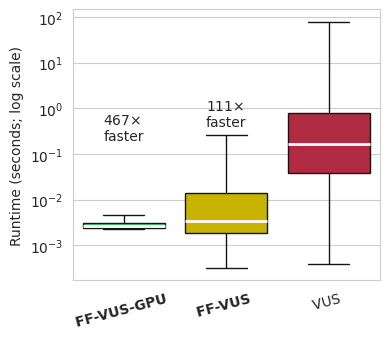

In [109]:
# What is the execution time difference
curr_df  = df[df['Metric'].isin(['AUC', 'FF-VUS-GPU (L: 128)', 'FF-VUS (L: 128)', 'VUS (L: 128)'])]
median_times = curr_df.groupby('Metric')['Metric time'].median()
order = median_times.sort_values().index.to_list()

plt.figure(figsize=(4, 3.5))

axis = sns.boxplot(
    y='Metric time',
    x='Metric',
    hue='Metric',
    data=curr_df,
    showfliers=False,
    log_scale=True,
    showmeans=False,
    meanprops=meanprops,
    medianprops=medianprops,
    palette=color_palette,
    order=order,
    saturation=1,
)
axis.set_ylabel('Runtime (seconds; log scale)')
axis.set_xlabel('')
axis.tick_params(axis='x', rotation=15)
axis.grid(visible=False, axis='x')

for i, metric in enumerate(order):
    if i == len(order) - 1:
        break
    axis.annotate(f'{speed_up_dict[metric]:.0f}$\\times$\nfaster', xy=(i - .2, 0.2 + i*0.2))

# Highlight the 2nd and 3rd xtick_label in bold
xticklabels = axis.get_xticklabels()
for idx in range(len(axis.get_xticklabels())):
    if 'FF-' in xticklabels[idx].get_text():
        xticklabels[idx].set_fontweight('bold')
    if '(L:' in xticklabels[idx].get_text(): 
        new_text = xticklabels[idx].get_text().replace('(L: 128)', '')
        xticklabels[idx].set_text(new_text)
axis.set_xticks(axis.get_xticks())
axis.set_xticklabels([label.get_text() for label in xticklabels])

finalize_plot(save_fig_path, 'exec_time_comparison_tsb_small')

### Error boxplot

In [9]:
current_metrics = ['FF-VUS (L: 128)', 'FF-VUS-GPU (L: 128)']
vus_df = df[df['Metric'] == 'VUS (L: 128)'].set_index('Time series')

values_df = df[df['Metric'].isin(current_metrics)][['Time series', 'Metric', 'Metric value']]
values_df = values_df.pivot(columns='Metric', index='Time series', values='Metric value')
dif_df = values_df.apply(lambda row: row - vus_df.loc[row.name]['Metric value'], axis=1).abs()
dif_df.head(3)

Metric,FF-VUS (L: 128),FF-VUS-GPU (L: 128)
Time series,,
Daphnet/S01R02E0.test.csv@1.out,0.0,1.677621e-08
Daphnet/S01R02E0.test.csv@4.out,0.0,7.568250e-07
Daphnet/S01R02E0.test.csv@6.out,0.0,5.137035e-08


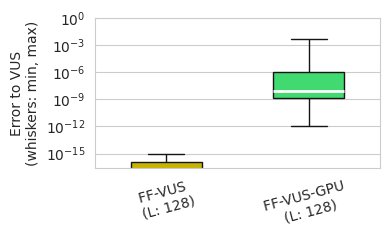

In [186]:
plt.figure(figsize=(4, 2.5))

axis = sns.boxplot(
    dif_df, 
    showfliers=False, 
    fill=True, 
    flierprops={"marker": "o"},
    medianprops=medianprops,
    width=.5, 
    palette=color_palette, 
    saturation=1,
    whis=[0, 100]
)
axis.set_ylabel('Error to VUS\n(whiskers: min, max)')
axis.set_xlabel('')
axis.tick_params(axis='x', rotation=15)
axis.grid(visible=False, axis='x')
axis.set_yscale('log')
axis.set_yticks([10**-x for x in range(0, 16)][::3])

# axis.annotate(f'Max error\n   9e-16', (0 - 0.2, 0.00005))
# axis.annotate(f'Max error\n   {dif_df['FF-VUS-GPU (L: 128)'].max():.3f}', (1 - 0.2, 0.00005))

# Highlight the 2nd and 3rd xtick_label in bold
xticklabels = axis.get_xticklabels()
for idx in range(len(axis.get_xticklabels())):
    if '(L:' in xticklabels[idx].get_text(): 
        new_text = xticklabels[idx].get_text().replace('(', '\n(')
        xticklabels[idx].set_text(new_text)
axis.set_xticks(axis.get_xticks())
axis.set_xticklabels([label.get_text() for label in xticklabels])

finalize_plot(save_fig_path, 'ffvus_error_analysis_tsb')

## Experiment 2: All metrics with default parameters on the synthetic datasets

In [11]:
curr_experiment_path = os.path.join(experiments_path, 'allmetrics_defparams_syn', 'results')
df = load_results(curr_experiment_path)    
df['Metric'] = df['Metric'].map(formal_names)
df.sample(3)

100%|██████████| 70/70 [00:00<00:00, 311.96it/s]


,Time series,Length,Number of anomalies,Anomalies average length,Metric,Metric value,Metric time,Slope size,Step,Global mask,...,Anomaly coordinates time,Safe mask time,Thresholds time,Score mask time,Position time,Slopes time,Existence time,Confusion matrix time,Precision recall curve time,Integral time
2010,syn_len_100000_n_50_avglen_10.npz,100000,50,10.0,AFFILIATION,0.924151,0.031120,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947,syn_len_100000_n_10_avglen_1.npz,100000,10,1.0,FF-VUS-GPU (L: 128),0.900642,0.003381,128.0,1.0,True,...,0.000461,0.000412,0.000221,0.000042,0.0001,0.000247,0.000208,0.000623,0.000106,0.000046
1231,syn_len_134217728_n_10_avglen_10.npz,134217728,10,10.0,RF,0.000000,600.418122,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Time series characteristics runtime analysis

In [12]:
length_analysis_df = df[df['Length'] != 100_000]
n_anomalies_analysis_df = df[np.logical_and(df['Time series'].str.contains('len_100000_'), df['Time series'].str.contains('_avglen_10.npz'))]
avg_anomaly_length_analysis_df = df[df['Time series'].str.contains('len_100000_n_10_')]

avg_anomaly_length_analysis_df.loc[:, 'Anomalies average length'] = avg_anomaly_length_analysis_df.apply(lambda row: int(row['Time series'].split('_')[-1].replace('.npz', '')), axis=1)
n_anomalies_analysis_df.loc[:, 'Number of anomalies'] = n_anomalies_analysis_df.apply(lambda row: int(row['Time series'].split('_')[-3]), axis=1)

analysis_dfs = [
    length_analysis_df, 
    n_anomalies_analysis_df, 
    avg_anomaly_length_analysis_df
]
attributes = ["Length", "Number of anomalies", "Anomalies average length"]

/home/sylli/anaconda3/envs/ffvus/lib/python3.12/site-packages/matplotlib/scale.py:270: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)
/tmp/ipykernel_13187/2316073209.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


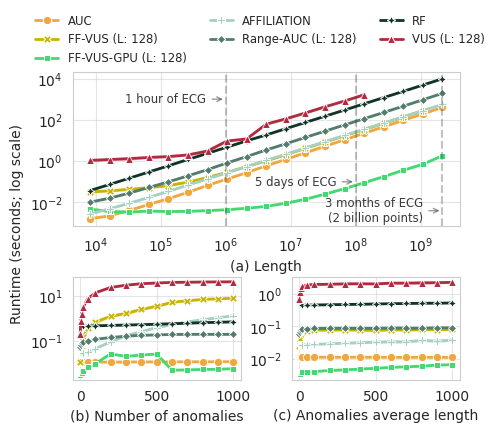

In [107]:
fig = plt.figure(figsize=(5, 4))
gs = GridSpec(2, 2, figure=fig, height_ratios=[3, 2], wspace=0.3, hspace=0.4)
attr_axis = {
    "Length": gs[0, :],
    "Number of anomalies": gs[1, 0],
    "Anomalies average length": gs[1, 1],
}
abc_numbered = {0: 'a', 1: 'b', 2: 'c'}

legend_axis = None
for i, attribute in enumerate(attributes):
    axis = fig.add_subplot(attr_axis[attribute])
    curr_df = analysis_dfs[i]

    sns.lineplot(
        x=attribute,
        y='Metric time',
        hue='Metric',
        data=curr_df,
        ax=axis,
        palette=color_palette,
        markers=True,
        style='Metric',
        dashes=False,
        linewidth=2,
        zorder=1,
        estimator=np.median
    )
    axis.set_yscale('log')
    axis.grid(axis='both', alpha=0.5)
    axis.set_xlabel(f"({abc_numbered[i]}) {attribute}")
    axis.set_ylabel('')

    if attribute == "Length":
        axis.set_xscale('log', base=10)
    if i != 0:
        axis.get_legend().remove()
    else:
        legend_axis = axis

        # 1 million points (~1 hour of ECG)
        x_val = 1e6
        y_val = 1000
        curr_color = "#383838"
        axis.annotate("1 hour of ECG",
                    xy=(x_val, y_val), xytext=(x_val / 2, y_val),
                    ha='right', va='center', fontsize='small', color=curr_color,
                    arrowprops=dict(arrowstyle="->", color=curr_color, alpha=0.5))
        axis.axvline(x=x_val, ymin=0, ymax=20000, color=curr_color, linestyle='--', alpha=0.3)

        # 100 million points (~5 days of ECG)
        x_val = 1e8
        y_val = 0.1
        axis.annotate("5 days of ECG",
                    xy=(x_val, y_val), xytext=(x_val / 2, y_val),
                    ha='right', va='center', fontsize='small', color=curr_color,
                    arrowprops=dict(arrowstyle="->", color=curr_color, alpha=0.5))
        axis.axvline(x=x_val, ymin=0, ymax=20000, color=curr_color, linestyle='--', alpha=0.3)

        # 1 billion points (~3 months of ECG)
        x_val = 2**31
        y_val = 0.004
        axis.annotate("3 months of ECG\n(2 billion points)",
                    xy=(x_val, y_val), xytext=(x_val / 2, y_val),
                    ha='right', va='center', fontsize='small', color=curr_color,
                    arrowprops=dict(arrowstyle="->", color=curr_color, alpha=0.5))
        axis.axvline(x=x_val, ymin=0, ymax=20000, color=curr_color, linestyle='--', alpha=0.3)

fig.text(
    0, 0.5,
    "Runtime (seconds; log scale)",
    va='center',
    rotation='vertical',
)

if legend_axis:
    handles, labels = legend_axis.get_legend_handles_labels()
    legend_axis.get_legend().remove()
    fig.legend(
        handles,
        labels,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.05),
        ncol=(len(labels)//2),
        # nrow=2,
        frameon=False,
        fontsize='small'
    )
finalize_plot(save_fig_path, 'exec_time_per_ts_char_syn')

### Computation step runtime analysis

In [51]:
rename_dict = {
    'Anomaly coordinates time': 'Anom.\ncoords',
    'Safe mask time': 'Mask',
    'Thresholds time': 'Thresh.',
    'Score mask time': 'Scores',
    'Position time': 'Pos.',
    'Slopes time': 'Buffers',
    'Existence time': 'Existence',
    'Confusion matrix time': 'Conf. mat.',
    'Precision recall curve time': 'PR curve',
    'Integral time': 'Integral',
}

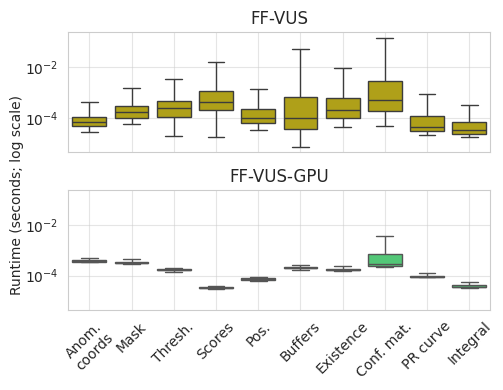

In [106]:
time_analysis_cols = [x for x in df.columns if 'time' in x and x != 'Metric time']
metrics = ['FF-VUS (L: 128)', 'FF-VUS-GPU (L: 128)']
curr_df = df[df['Metric'].isin(metrics)]

fig, ax = plt.subplots(2, 1, figsize=(5, 4), sharey=True)
for i, col in enumerate(time_analysis_cols):
    for j, axis in enumerate(ax):
        sns.boxplot(
            curr_df[curr_df['Metric'] == metrics[j]], 
            ax=axis, 
            x=i, 
            y=col, 
            log_scale=True, 
            legend=(i == 0), 
            color=color_palette[metrics[j]], 
            showfliers=False
        )
        if j != 0:
            axis.set_xticks(np.arange(len(time_analysis_cols)), [rename_dict[x] for x in time_analysis_cols])
        else:
            axis.set_xticks(np.arange(len(time_analysis_cols)), [])

        axis.set_title(metrics[j].replace(' (L: 128)', ''))
        axis.set_ylabel('')
        axis.set_xlabel('')
        axis.tick_params(axis='x', rotation=45)
        axis.grid(axis='both', alpha=0.5)

fig.text(
    0, 0.5,
    "Runtime (seconds; log scale)",
    va='center',
    rotation='vertical',
)

finalize_plot(save_fig_path, 'per_part_runtime_syn')

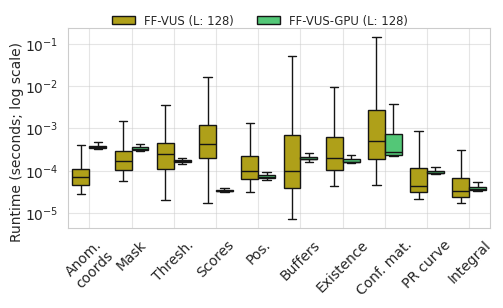

In [105]:
time_analysis_cols = [x for x in df.columns if 'time' in x and x != 'Metric time']
metrics = ['FF-VUS (L: 128)', 'FF-VUS-GPU (L: 128)']
curr_df = df[df['Metric'].isin(metrics)]

fig, axis = plt.subplots(1, 1, figsize=(5, 3))
for i, col in enumerate(time_analysis_cols):
    sns.boxplot(
        curr_df, 
        ax=axis, 
        x=i, 
        y=col, 
        log_scale=True, 
        legend=(i == 0), 
        hue='Metric',
        palette=color_palette, 
        showfliers=False
    )
    if j != 0:
        axis.set_xticks(np.arange(len(time_analysis_cols)), [rename_dict[x] for x in time_analysis_cols])
    else:
        axis.set_xticks(np.arange(len(time_analysis_cols)), [])

    axis.set_title('')
    axis.set_ylabel('')
    axis.set_xlabel('')
    axis.tick_params(axis='x', rotation=45)
    axis.grid(axis='both', alpha=0.5)
    axis.legend()

fig.text(
    0, 0.57,
    "Runtime (seconds; log scale)",
    va='center',
    rotation='vertical',
)

handles, labels = axis.get_legend_handles_labels()
axis.get_legend().remove()
fig.legend(
    handles,
    labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.03),
    ncol=len(labels),
    frameon=False,
    fontsize='small'
)

finalize_plot(save_fig_path, 'per_part_runtime_syn')

## Experiment 3: VUS / Buffer & Step comparison / TSB

### Buffer comparison

In [134]:
curr_experiment_path = os.path.join(experiments_path, 'vus_buffer_comparison_tsb', 'results')
df = load_results(curr_experiment_path)    
df['Metric'] = df['Metric'].map(formal_names)
df.sample(3)

100%|██████████| 30/30 [00:00<00:00, 90.76it/s]


,Time series,Length,Number of anomalies,Anomalies average length,Slope size,Step,Global mask,Slopes,Existence,Confusion matrix,...,Score mask time,Position time,Slopes time,Existence time,Confusion matrix time,Precision recall curve time,Integral time,Metric,Metric value,Metric time
6895,YAHOO/YahooA3Benchmark-TS3_data.out,1679,6,1.0,256,1.0,True,function,True,dynamic_plus,...,0.000012,0.000070,0.000192,0.000159,0.001213,0.000091,0.000035,FF-VUS-GPU (L: 128),0.959300,0.003211
1422,GHL/20_Lev_fault_Temp_corr_seed_67_vars_23.tes...,200000,1,144.0,16,1.0,True,precomputed,optimized,dynamic_plus,...,0.002898,0.000093,0.000060,0.000169,0.000149,0.000044,0.000034,FF-VUS (L: 128),0.006594,0.012013
17562,OPPORTUNITY/S3-ADL4.test.csv@56.out,27540,2,1080.0,32,1.0,True,function,True,dynamic_plus,...,0.000032,0.000071,0.000202,0.000160,0.000450,0.000089,0.000035,FF-VUS-GPU (L: 128),0.071973,0.002616


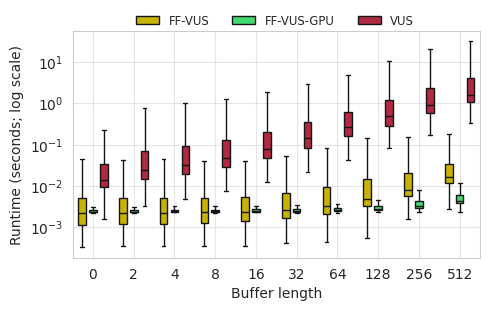

In [135]:
fig, axis = plt.subplots(1, 1, figsize=(5, 3))
axis = sns.boxplot(
    ax=axis,
    y='Metric time', 
    x='Slope size', 
    hue='Metric', 
    data=df, 
    showfliers=False, 
    log_scale=True, 
    palette=color_palette, 
    saturation=1,
    gap=.3,
)
plt.xlabel('Buffer length')
plt.ylabel('Runtime (seconds; log scale)')
plt.grid(axis='both', alpha=0.5)

handles, labels = axis.get_legend_handles_labels()
labels = [label.replace(' (L: 128)', '') for label in labels]
axis.get_legend().remove()
fig.legend(
    handles,
    labels,
    loc='upper center',
    bbox_to_anchor=(0.56, 1.04),
    ncol=len(labels),
    frameon=False,
    fontsize='small'
)

finalize_plot(save_fig_path, 'exec_time_buffer_comparison')

### Step comparison

In [136]:
curr_experiment_path = os.path.join(experiments_path, 'vus_step_comparison_tsb', 'results')
df_step = load_results(curr_experiment_path)    
df_step['Metric'] = df_step['Metric'].map(formal_names)
df_step.sample(3)

100%|██████████| 20/20 [00:00<00:00, 109.07it/s]


,Time series,Length,Number of anomalies,Anomalies average length,Slope size,Step,Global mask,Slopes,Existence,Confusion matrix,...,Score mask time,Position time,Slopes time,Existence time,Confusion matrix time,Precision recall curve time,Integral time,Metric,Metric value,Metric time
28062,KDD21/002_UCR_Anomaly_DISTORTED2sddb40_35000_5...,80000,1,300.0,512,512,True,precomputed,optimized,dynamic_plus,...,0.001250,0.000095,0.000035,0.000085,0.000424,0.000031,0.000025,FF-VUS (L: 128),0.020632,0.005801
32619,OPPORTUNITY/S1-ADL2.test.csv@81.out,31891,2,697.5,512,16,True,precomputed,optimized,dynamic_plus,...,0.000546,0.000164,0.000193,0.000136,0.001169,0.000049,0.000030,FF-VUS (L: 128),0.300071,0.003675
37529,KDD21/006_UCR_Anomaly_DISTORTEDCIMIS44AirTempe...,8183,1,24.0,512,16,True,function,True,dynamic_plus,...,0.000032,0.000069,0.000193,0.000163,0.000287,0.000088,0.000036,FF-VUS-GPU (L: 128),0.160874,0.002439


In [160]:
df_vus_512 = df[np.logical_and(df['Metric'] == 'VUS (L: 128)', df['Slope size'] == 512)]

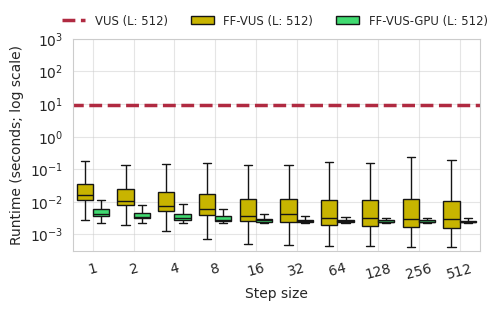

In [ ]:
fig, axis = plt.subplots(1, 1, figsize=(5, 3))
plt.hlines(df_vus_512['Metric time'].mean(), xmin=-1, xmax=512, lw=2.5, color=color_palette['VUS (L: 128)'], linestyle='--', label='VUS (L: 512)')
sns.boxplot(
    y='Metric time', 
    x='Step', 
    data=df_step, 
    showfliers=False, 
    log_scale=True,
    hue='Metric',
    palette=color_palette,
    saturation=1,
    ax=axis
)
axis.set_xlabel('Step size')
axis.set_ylabel('Runtime (seconds; log scale)')
axis.tick_params(axis='x', labelrotation=15)
axis.set_yticks([10**i for i in range(-3, 4)])
axis.grid(axis='both', alpha=0.5)

handles, labels = axis.get_legend_handles_labels()
labels = [label.replace(' (L: 128)', ' (L: 512)') for label in labels]
axis.get_legend().remove()
fig.legend(
    handles,
    labels,
    loc='upper center',
    bbox_to_anchor=(0.56, 1.04),
    ncol=len(labels),
    frameon=False,
    fontsize='small'
)

finalize_plot(save_fig_path, 'exec_time_step_comparison')

In [182]:
df_vus_512_control = df_vus_512.set_index('Time series')['Metric value']

df_step['Error'] = df_step.apply(lambda row: row['Metric value'] - df_vus_512_control.loc[row['Time series']], axis=1)
df_step.sample(3)

,Time series,Length,Number of anomalies,Anomalies average length,Slope size,Step,Global mask,Slopes,Existence,Confusion matrix,...,Slopes time,Existence time,Confusion matrix time,Precision recall curve time,Integral time,Metric,Metric value,Metric time,Dif. to VUS,Error
27256,SMD/machine-1-8.test.csv@11.out,23698,20,38.150000,512,512,True,precomputed,optimized,dynamic_plus,...,0.000238,0.000588,0.005520,0.000050,0.000039,FF-VUS (L: 128),0.344831,0.010045,-0.086505,-0.086505
13285,ECG/MBA_ECG14046_data_43.out,229899,376,83.244681,512,64,True,function,True,dynamic_plus,...,0.001095,0.000189,0.002746,0.000090,0.000036,FF-VUS-GPU (L: 128),0.665330,0.006066,-0.026083,-0.026083
14801,NAB/NAB_data_tweets_4.out,15851,3,507.666667,512,64,True,function,True,dynamic_plus,...,0.000198,0.000161,0.000346,0.000088,0.000045,FF-VUS-GPU (L: 128),0.193224,0.002527,-0.001925,-0.001925


/home/sylli/anaconda3/envs/ffvus/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


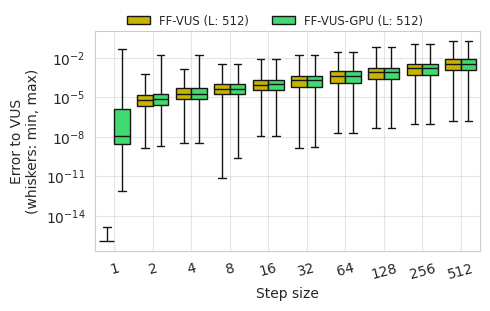

In [183]:
fig, axis = plt.subplots(1, 1, figsize=(5, 3))    
sns.boxplot(
    y='Error', 
    x='Step', 
    data=df_step, 
    showfliers=False, 
    log_scale=True,
    hue='Metric',
    palette=color_palette,
    saturation=1,
    ax=axis,
    whis=[0, 100]
)
axis.set_xlabel('Step size')
axis.set_ylabel('Error to VUS\n(whiskers: min, max)')
axis.tick_params(axis='x', labelrotation=15)
# axis.set_yticks([10**i for i in range(-3, 4)])
axis.grid(axis='both', alpha=0.5)

handles, labels = axis.get_legend_handles_labels()
labels = [label.replace(' (L: 128)', ' (L: 512)') for label in labels]
axis.get_legend().remove()
fig.legend(
    handles,
    labels,
    loc='upper center',
    bbox_to_anchor=(0.56, 1.04),
    ncol=len(labels),
    frameon=False,
    fontsize='small'
)

finalize_plot(save_fig_path, 'error_step_comparison')

## Experiment 4: Equivalence to AUC

In [ ]:
curr_experiment_path = os.path.join(experiments_path, 'vus_ffvus_auc_0_tsb', 'results')
df = load_results(curr_experiment_path)    
df['Metric'] = df['Metric'].map(formal_names)
df.sample(3)

100%|██████████| 4/4 [00:00<00:00, 109.64it/s]


,Time series,Length,Number of anomalies,Anomalies average length,Slope size,Step,Global mask,Slopes,Existence,Confusion matrix,...,Score mask time,Position time,Slopes time,Existence time,Confusion matrix time,Precision recall curve time,Integral time,Metric,Metric value,Metric time
4269,OPPORTUNITY/S1-ADL5.test.csv@90.out,30047,2,609.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AUC,0.107421,0.002552
5826,IOPS/KPI-c69a50cf-ee03-3bd7-831e-407d36c7ee91....,149158,59,11.898305,0.0,NaN,NaN,NaN,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VUS (L: 128),0.004193,0.108525
6425,SMD/machine-2-4.test.csv@19.out,23688,20,84.700000,0.0,NaN,NaN,NaN,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VUS (L: 128),0.112668,0.024168


In [232]:
values_df = df[['Time series', 'Metric', 'Metric value']]
values_df = values_df.pivot(columns='Metric', index='Time series', values='Metric value')
dif_df = values_df.copy()
for metric in metrics: 
    dif_df[metric] = values_df[metric] - values_df['AUC']

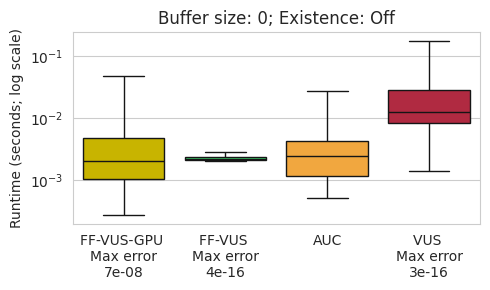

In [234]:
metrics = df['Metric'].unique()
median_times = df.groupby('Metric')['Metric time'].median()
order = median_times.sort_values().index.to_list()

fig, axis = plt.subplots(1, 1, figsize=(5, 3))
sns.boxplot(
    y='Metric time', 
    x='Metric', 
    hue='Metric', 
    data=df, 
    showfliers=False, 
    log_scale=True, 
    palette=color_palette, 
    order=order, 
    ax=axis,
    saturation=1
)
axis.set_xlabel('')
axis.set_ylabel('Runtime (seconds; log scale)')
axis.set_title('Buffer size: 0; Existence: Off')
axis.set_xticks(np.arange(len(metrics)), [x.replace('(L: 128)', f'\nMax error\n{dif_df.max()[x]:.0e}') for x in metrics])

finalize_plot(save_fig_path, 'exec_time_auc_equivalence')

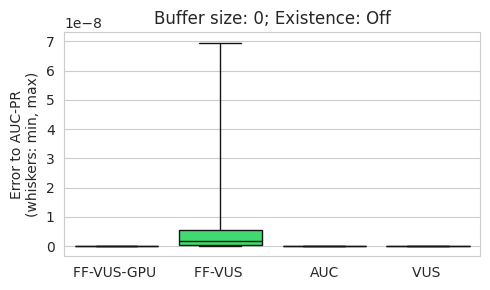

In [230]:
fig, axis = plt.subplots(1, 1, figsize=(5, 3))

sns.boxplot(
    dif_df.abs(), 
    showfliers=True, 
    palette=color_palette, 
    order=order, 
    log_scale=False, 
    ax=axis,
    saturation=1,
    whis=[0, 100]
)
axis.set_xlabel('')
axis.set_ylabel('Error to AUC-PR\n(whiskers: min, max)')
axis.set_title('Buffer size: 0; Existence: Off')
axis.set_xticks(np.arange(len(metrics)), [x.replace('(L: 128)', '(L: 0, E: Off)') for x in metrics])
axis.set_xticks(np.arange(len(metrics)), [x.replace('(L: 128)', '') for x in metrics])

finalize_plot(save_fig_path, 'error_auc_equivalence')